In [1]:
import numpy as np
import FactorBP as FB
import scipy.io as sio
import matlab.engine
import time
eng = matlab.engine.start_matlab()

In [2]:
def ComputeAccurancy(Decode, gTruth, NofInliers):
    Ccnt = 0
    for i in range(NofInliers):
        if(Decode[i] == gTruth[i]):
            Ccnt += 1
    return 1.0 * Ccnt / NofInliers

def LoadHouse():
    res = np.zeros([111, 30, 2])
    for i in range(1,112):
        res[i-1] = np.loadtxt('data/cmum/house/label/house%d' %i)
    return res

HouseData = LoadHouse()
NofAlgorithms = 5
# AlgorithmNames=['Ours', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM', 'OursPW', 'Ours-BCA']
AlgorithmNames=['IPFP', 'Ours-PW', 'FGM', 'RRWM', 'SM']
start = 0
end = 111
MeanAcc = np.zeros([10,NofAlgorithms])
MeanRtime = np.zeros([10, NofAlgorithms])
MeanObj = np.zeros([10, NofAlgorithms])
AllAcc = {}
AllRtim = {}
AllObj = {}
Type = 'topo'

for baseline in xrange(10,101,10):
    print(' Start baseline: %d' % (baseline))
    AllAcc[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    AllRtim[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    # AllObj[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    Obj = np.zeros([NofAlgorithms, end - baseline])

    for ImageI in range(start, end - baseline):
        # print(' Image: %d' % (ImageI))
        PT1 = np.copy(HouseData[ImageI])
        PT2 = np.copy(HouseData[ImageI+baseline])
        NofNodes = 30
        gTruth = np.random.permutation(NofNodes)
        PT1 = PT1[gTruth, :]
        PF1 = np.zeros([NofNodes,1])
        PF2 = np.zeros([NofNodes,2])
        MG1 = FB.MatchingGraph(PT1[0:NofNodes], PF1[0:NofNodes])
        MG2 = FB.MatchingGraph(PT2[0:NofNodes], PF2[0:NofNodes])

        [G, FName] = FB.ConstructMatchingModel(MG1, MG2, Type, False, True)
        # G2 = FB.ConstructMatchingModel(MG1, MG2, Type, False, True)
        [Gvis, FName] = FB.ConstructMatchingModel(MG1, MG2, Type, False, True)
        G.SetVerbose(False)
        
        # IPFP
        resIPFP = eng.runIPFP(FName, nargout=3)
        AllAcc[(baseline-10)/10][0][ImageI] = ComputeAccurancy(resIPFP[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][0][ImageI] = resIPFP[0]
        cDecode = FB.intArray(NofNodes)
        for i in range(NofNodes):
            cDecode[i] = int(resIPFP[1][0][i])
        Obj[0][ImageI] = Gvis.ComputeObj(cDecode)
        #end IPFP
        
        #  Our-PW
        res = FB.BaBSolver(G, 30, 10, 0.005, False)
        AllAcc[(baseline-10)/10][1][ImageI] = ComputeAccurancy(res.Decode, gTruth, NofNodes)
        AllRtim[(baseline-10)/10][1][ImageI] = res.Time
        Obj[1][ImageI] = res.Value
        #end Our-PW
        
        # FGM
        #resFGM = eng.runSM(FName, nargout=3)
        resFGM = eng.runFGM(FName, nargout=3)
        AllAcc[(baseline-10)/10][2][ImageI] = ComputeAccurancy(resFGM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][2][ImageI] = resFGM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resFGM[1][0][i])
        Obj[2][ImageI] = Gvis.ComputeObj(cDecode)
        #end FGM
        
        # RRWM
        resRRWM = eng.runRRWM(FName, nargout=3)
        AllAcc[(baseline-10)/10][3][ImageI] = ComputeAccurancy(resRRWM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][3][ImageI] = resRRWM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resRRWM[1][0][i])
        Obj[3][ImageI] = Gvis.ComputeObj(cDecode)
        #end RRWM
        
        # SpectralMatching
        # resSM = eng.runIPFP(nargout=3)
        resSM = eng.runSM(FName, nargout=3)
        AllAcc[(baseline-10)/10][4][ImageI] = ComputeAccurancy(resSM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][4][ImageI] = resSM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resSM[1][0][i])
        Obj[4][ImageI] = Gvis.ComputeObj(cDecode)
        #end SpectralMatching
        
        
        
        MaxObj = np.max(Obj[:,ImageI])
        Obj[:,ImageI] /= MaxObj
        AllObj[(baseline-10)/10] = Obj
        #for ai in xrange(NofAlgorithms):
        #    print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
        #                                                     AllAcc[(baseline-10)/10][ai][ImageI],
        #                                                    AllRtim[(baseline-10)/10][ai][ImageI],
        #                                                   AllObj[(baseline-10)/10][ai][ImageI]))
        #print(' Finished Frame: %d ----------------------' % (ImageI) )
        #end inner loop
    for ai in xrange(NofAlgorithms):
        MeanAcc[(baseline-10)/10][ai] = np.mean(AllAcc[(baseline-10)/10][ai])
        MeanRtime[(baseline-10)/10][ai] = np.mean(AllRtim[(baseline-10)/10][ai])
        # MeanObj[(baseline-10)/10][ai] = np.mean(Obj[ai])
        MeanObj[(baseline-10)/10][ai] = np.mean(AllObj[(baseline-10)/10][ai])
        print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                        MeanAcc[(baseline-10)/10][ai],
                                                        MeanRtime[(baseline-10)/10][ai],
                                                        MeanObj[(baseline-10)/10][ai]))
    print('××××××××××××××××××××')
    #end outer loop

/usr/lib/pymodules/python2.7/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=medium. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


array([ 0.12343234,  0.12124542,  0.11234568,  0.1084507 ,  0.08961749,
        0.08039216,  0.05853659,  0.06236559,  0.05873016,  0.05454545])

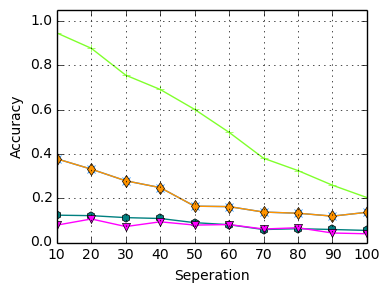

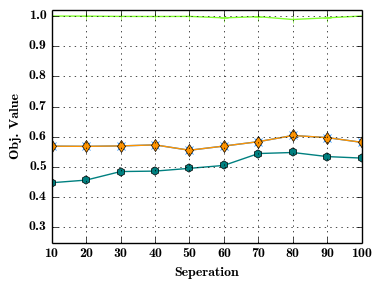

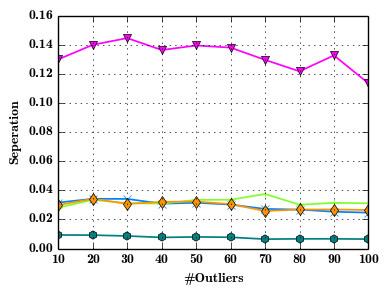

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import pylab
%matplotlib inline


Colors = [[ 0.        ,  0.5       , 0.5        ,  1.        ],   #1
          [ 1.        ,  0.00196078,  1.        ,  1.        ],   #2
          [ 0.        ,  0.50392157,  1.        ,  1.        ],   #3
          # [ 0.08538899,  1.        ,  0.88235294,  1.        ],   #4
          # [ 0.49019608,  1.        ,  0.47754586,  1.        ],   #5
          [ 0.5       ,  1.        ,  0.17273877,  1.        ],   #6
          [ 1.        ,  0.58169935,  0.        ,  1.        ],   #7
          # [ 1.        ,  0.11692084,  0.        ,  1.        ],   #8
          # [ 1.        ,  0.        ,  1.        ,  1.        ]    #9
          ]
Seq = [0, 1, 2, 3, 4]
AlgorithmNames=['IPFP', 'Ours-PW', 'FGM', 'RRWM', 'SM']
Markers = ['h', 'v', 'x', '+', 'd']

figData = pylab.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
ax = pylab.gca()

matplotlib.rc('font',family='Times New Roman')


#plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')

for ai in xrange(NofAlgorithms):
    pylab.plot(range(10,101,10), MeanAcc[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
pylab.ylim([0,1.05])
pylab.grid(True)

pylab.ylabel('Accuracy')
pylab.xlabel('Seperation')

figLegend = pylab.figure(figsize = (11.7,0.4))
pylab.figlegend(*ax.get_legend_handles_labels(), loc = 'upper center',  ncol=9, shadow=True, fancybox=True)
figData.savefig('results/'+Type+'/EdgesOnly/House_Acc.pdf')
#figLegend.savefig("legend.pdf")
figLegend.show()

#plt.legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5,-0.25), ncol=9)
#plt.savefig('House_ACC.pdf')    # <-- loses transparency

StoreForPlot ={}
StoreForPlot['Accuracy'] = MeanAcc
StoreForPlot['Time'] = MeanRtime
StoreForPlot['Obj'] = MeanObj

sio.savemat('results/'+Type+'/EdgesOnly/PlotData.mat', StoreForPlot)

plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    if(AlgorithmNames[Seq[ai]] == 'Ours-PW'):
        continue
    plt.plot(range(10,101,10), MeanObj[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
plt.ylim([0.25,1.02])
plt.ylabel('Obj. Value')
plt.xlabel('Seperation')
plt.grid(True)

plt.savefig('results/'+Type+'/EdgesOnly/House_Obj.pdf')    # <-- loses transparency


plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    plt.plot(range(10,101,10), MeanRtime[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]], linewidth=1.25)

plt.ylabel('Seperation')
plt.xlabel('#Outliers')

plt.grid(True)
plt.savefig('results/'+Type+'/EdgesOnly/Car_Time.pdf')    # <-- loses transparency

MeanAcc[:,0]

In [ ]:
PT1 = np.copy(HouseData[ImageI])
PT2 = np.copy(HouseData[ImageI+baseline])
NofNodes = 30
gTruth = np.random.permutation(NofNodes)
PT1 = PT1[gTruth, :]
PF1 = np.zeros([NofNodes,1])
PF2 = np.zeros([NofNodes,2])
MG1 = FB.MatchingGraph(PT1[0:NofNodes], PF1[0:NofNodes])
MG2 = FB.MatchingGraph(PT2[0:NofNodes], PF2[0:NofNodes])
[G,FName] = FB.ConstructMatchingModel(MG1, MG2, 'cmu', False, True)
res1 = FB.BaBSolver(G, 30, 10, 0.005, True)